In [61]:
import math
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self.grad = 0.0
        self._backward = lambda: None
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        add = Value(self.data + other.data, (self,other), '+')

        def _backward():
            self.grad += 1.0 * add.grad
            other.grad += 1.0 * add.grad
        add._backward = _backward

        return add
    
    def __radd__(self,other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        mul = Value(self.data * other.data, (self,other), '*')

        def _backward():
            self.grad += other.data * mul.grad
            other.grad += self.data * mul.grad
        
        mul._backward = _backward

        return mul
    
    def __pow__(self,other):
        assert isinstance(other, (int,float)), "only supporting int/float powers for now"
        out = Value(self. data**other, (self,), f"**{other}")

        def _backward():
            self.grad += other * (self.data ** (other-1)) * out.grad
        out._backward = _backward

        return out

    def __rmul__(self,other): # other * self
        return self * other
    
    def __truediv__(self,other): # self / other
        return self * other**-1
    
    def __neg__(self): # -self
        return self * -1

    def __sub__(self,other): # self - other
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t =  (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [64]:
a = Value(8.0)
b = Value(2.0)
# a / b
a - b

Value(data=6.0)

In [6]:
from graphviz import Digraph

def trace(root):
    # Builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
                
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right
    
    nodes, edges = trace(root)
    
    for n in nodes:
        uid = str(id(n))

        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        
        if n._op:
            # Create an op node for the operation that produced this value
            dot.node(name=uid + n._op, label=n._op)
            # Connect the operation node to the value node
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # Connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot


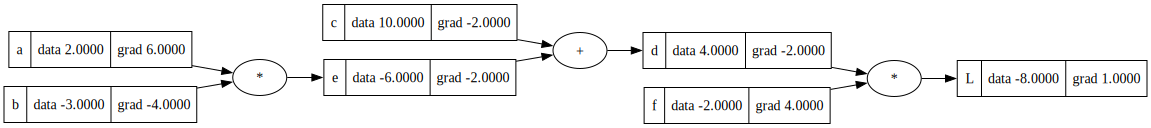

In [54]:
draw_dot(L)

In [65]:
## inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

## weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

## bias of the neuron
b = Value(6.8813735870195432, label='b')

## x1w1 + x2w2 + b 
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n' 
o = n.tanh(); o.label = 'o'
o.backward()

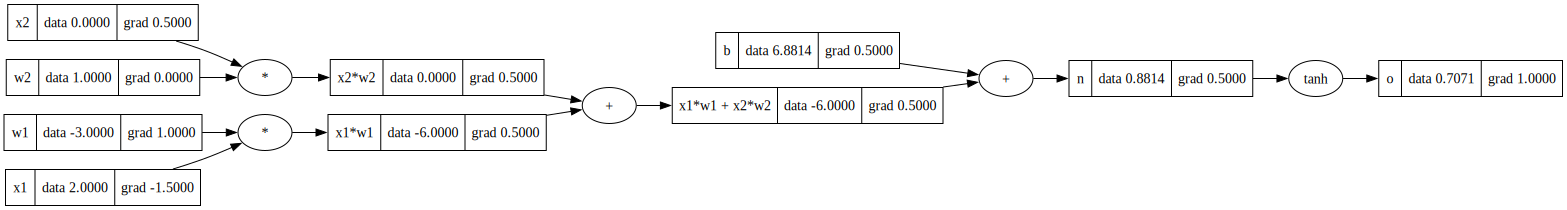

In [34]:
draw_dot(o)

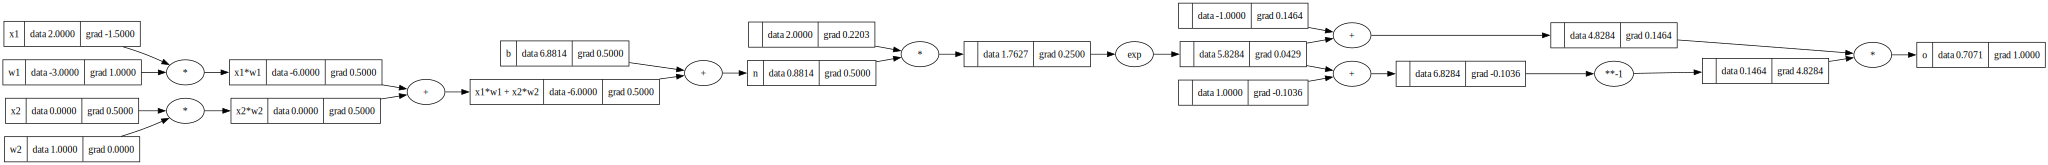

In [66]:
## inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

## weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

## bias of the neuron
b = Value(6.8813735870195432, label='b')

## x1w1 + x2w2 + b 
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n' 
# -----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ------
o.label = 'o'
o.backward()
draw_dot(o)

In [279]:
import random
class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w,x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]
  
class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    # return [p for neuron in self.neurons for p in neuron.parameters()]
    params = []
    for neuron in self.neurons:
      ps = neuron.parameters()
      params.extend(ps)
    return params

class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self,x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    params = []
    for layer in self.layers:
      ps = layer.parameters()
      params.extend(ps)
    return params
    
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=0.5583208923500581)

In [ ]:
draw_dot(n(x))

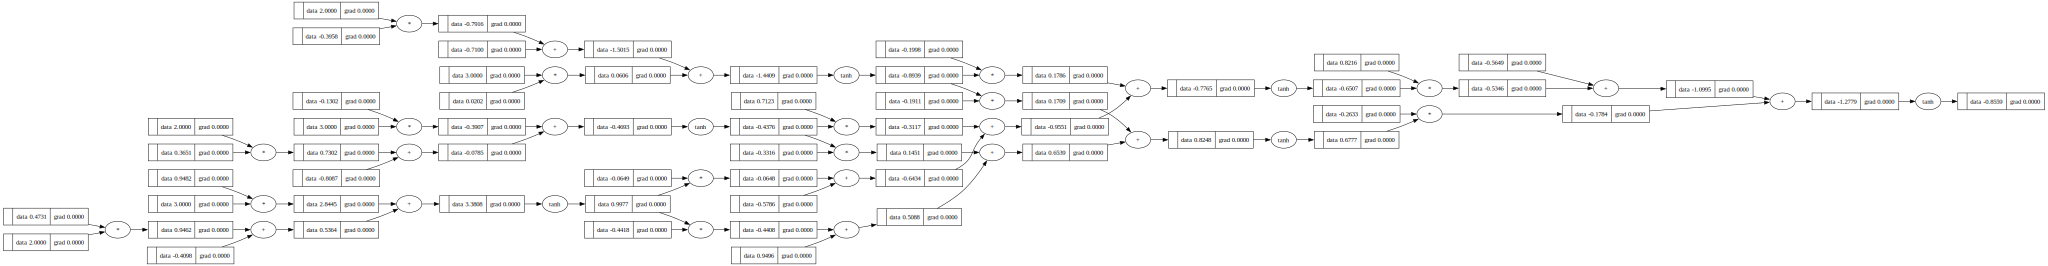

In [3]:
'''Definging MLP using MLP class'''
o = MLP(2,[3,2,1])
out = o([2,3])
draw_dot(out)